Last Updated: 10/29/2023

### Deep Learning: LSTM
##### I will be using Google historical stock data from 2010. 

In [25]:
# Copyright 2023 Shane Khalid. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

#### Install and Import libraries
##### Make sure GPU is being used

In [1]:
import yfinance as yf

import tensorflow as tf
from tensorflow import keras

from keras.layers import GRU, Dropout, SimpleRNN, LSTM, Dense, SimpleRNN, GRU
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead.")

import pandas as pd
import numpy as np

import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from keras.metrics import Accuracy
from keras.metrics import F1Score
from keras.metrics import Precision


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import precision_score
#from sklearn.metrics import f1_score

%matplotlib inline

2023-10-29 20:36:59.453125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 20:36:59.453275: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 20:36:59.453567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 20:36:59.507390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 20:37:03.708737: I tensorflow/compiler/

Num GPUs Available:  1
GPU is available and being used.


#### Import Data using yfinance API into pandas Dataframe

In [2]:
googl_df = yf.download("GOOGL", start="2010-01-01", end="2023-10-26")
googl_df
     

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028
...,...,...,...,...,...,...
2023-10-19,138.500000,139.660004,137.380005,137.750000,137.750000,26066000
2023-10-20,137.330002,137.869995,135.080002,135.600006,135.600006,26315200
2023-10-23,135.039993,137.660004,133.949997,136.500000,136.500000,26317900


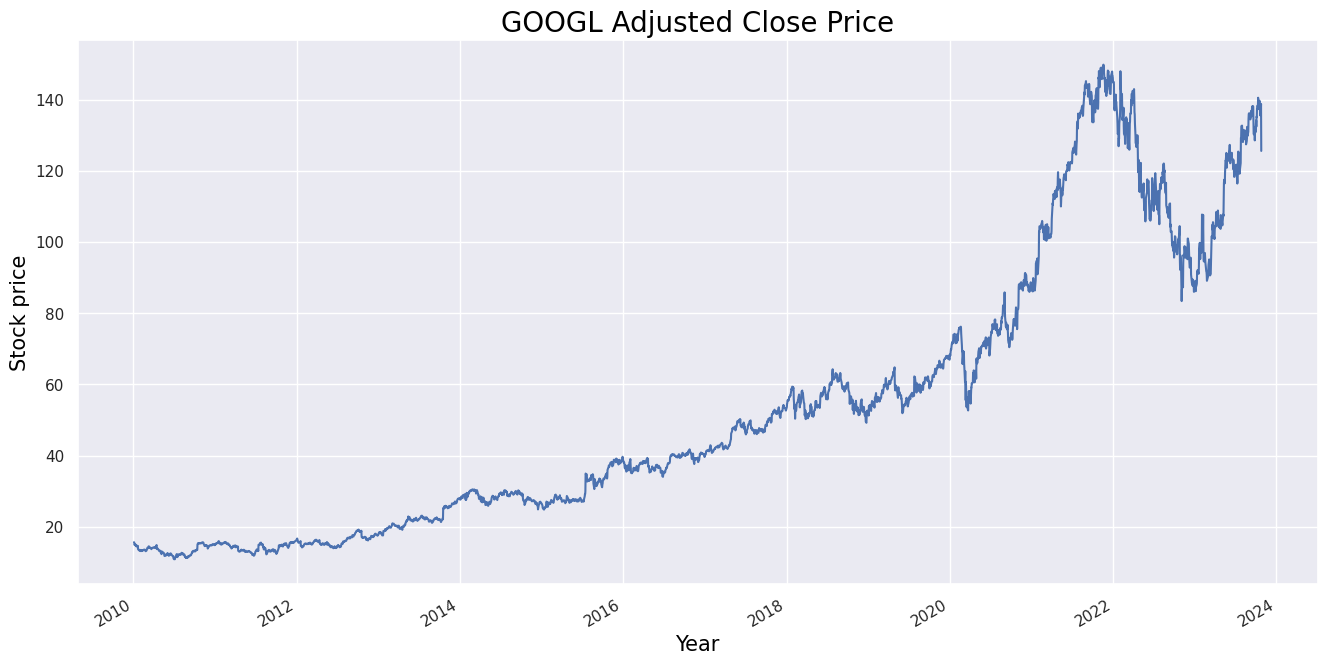

In [4]:
# Plot Adjusted Close price

googl_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(16, 8)})
plt.title('GOOGL Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [5]:
# create dataframe for adjusted closing price
googl_adj = googl_df[['Adj Close']]
googl_adj

,Adj Close
Date,
2010-01-04,15.684434
2010-01-05,15.615365
2010-01-06,15.221722
2010-01-07,14.867367
2010-01-08,15.065566
...,...
2023-10-19,137.750000
2023-10-20,135.600006
2023-10-23,136.500000


### Step 4. Create Training Dataset
##### 80% Training set

In [6]:
# Convert DataFrame to numpy array
googl_adj_arr = googl_adj.values

# Find number of rows to train model on (80% of data set) 
training_data_len = int(0.8*len(googl_adj))

training_data_len

2781

In [7]:
# Create train data set
train = googl_adj_arr[0:training_data_len, :]


### Feature Scaling
##### Normalize training data before fitting to model by converting vvalues of numeric columns in dataset to a common scale. Also use sklearn to scale the data to between 0 and 1 to help performance

In [8]:
# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.05742836],
       [0.05659711],
       [0.05185961],
       ...,
       [0.90826299],
       [0.94247261],
       [1.        ]])

In [9]:
train_scaled.shape

(2781, 1)

### Split training data into X_train, y_train

In [10]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 165 time-steps and 1 output
for i in range(165, len(train_scaled)):
    X_train.append(train_scaled[i-165:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 166:     # 165 days for first pass, 166 for second
      print(X_train)
      print(y_train)
      print()

[array([0.05742836, 0.05659711, 0.05185961, 0.04759494, 0.04998027,
       0.0497062 , 0.04650469, 0.0454837 , 0.04631495, 0.04334836,
       0.04564332, 0.04347183, 0.04424586, 0.03431607, 0.03130129,
       0.03203013, 0.03193375, 0.02958157, 0.02827145, 0.02919907,
       0.02862684, 0.03154825, 0.02731973, 0.02867804, 0.0293346 ,
       0.03022909, 0.02962976, 0.03021704, 0.02922919, 0.03169282,
       0.03076218, 0.03227108, 0.03153018, 0.03214458, 0.02981648,
       0.02873224, 0.02721432, 0.02732575, 0.02909969, 0.03162053,
       0.03290356, 0.03569545, 0.03859276, 0.03807173, 0.03738205,
       0.04227918, 0.0436917 , 0.04320981, 0.03828256, 0.03889094,
       0.03899937, 0.03925235, 0.03732482, 0.03657188, 0.03401188,
       0.03652067, 0.03819221, 0.03813498, 0.0380627 , 0.03934572,
       0.0394692 , 0.03997517, 0.04064078, 0.03980049, 0.03839099,
       0.03958063, 0.03919814, 0.04115881, 0.04538732, 0.04605895,
       0.04795635, 0.03435824, 0.03434317, 0.03583098, 0.0356

In [11]:
# Convert X_train and y_train to numpy arrays for training LSTM model
X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2616, 165, 1)

Create and train model We will create and train a model with four recurrent layers each with 50 neurons, input shape of data with number of time steps (60) and dimensionality (1), and an output layer with time step of 1, and the tanh activation function. Dropout will be used after each hidden layer as a regularisation technique to prevent overfitting. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimizer then fitted on the training set for 200 epochs with a batch size of 64.


In [13]:
# Build model - LSTM with 50 neurons and 4 hidden layers  

LSTM_model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
LSTM_model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
LSTM_model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
LSTM_model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, activation='tanh'))
LSTM_model.add(Dropout(0.2))
# Adding the output layer
LSTM_model.add(Dense(units = 1))

LSTM_model.summary()

2023-10-29 20:39:58.072162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 20:39:58.072289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 20:39:58.072327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 20:39:58.852681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 20:39:58.852823: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 165, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 165, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 165, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 165, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 165, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 165, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [14]:
# Compiling the LSTM
LSTM_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['MAE', 'F1Score', 'Accuracy', 'Precision'])
# Fitting the RNN to the Training set
LSTM_model.fit(X_train, y_train, epochs = 200, batch_size = 64)

Epoch 1/200


2023-10-29 20:42:36.434650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-29 20:42:38.419244: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6e59eb25c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-29 20:42:38.419297: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-10-29 20:42:38.458022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-29 20:42:38.794013: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 [==============================] - 10s 68ms/step - loss: 0.0174 - MAE: 0.0851 - f1_score: 0.4930 - Accuracy: 3.8226e-04 - precision: 1.0000
Epoch 2/200
41/41 [==============================] - 3s 61ms/step - loss: 0.0029 - MAE: 0.0356 - f1_score: 0.4930 - Accuracy: 3.8226e-04 - precision: 1.0000
Epoch 3/200
41/41 [==============================] - 3s 62ms/step - loss: 0.0024 - MAE: 0.0327 - f1_score: 0.4930 - Accuracy: 3.8226e-04 - precision: 1.0000
Epoch 4/200
41/41 [==============================] - 2s 61ms/step - loss: 0.0024 - MAE: 0.0331 - f1_score: 0.4930 - Accuracy: 3.8226e-04 - precision: 1.0000
Epoch 5/200
41/41 [==============================] - 3s 71ms/step - loss: 0.0022 - MAE: 0.0312 - f1_score: 0.4930 - Accuracy: 3.8226e-04 - precision: 1.0000
Epoch 6/200
41/41 [==============================] - 2s 61ms/step - loss: 0.0022 - MAE: 0.0312 - f1_score: 0.4930 - Accuracy: 3.8226e-04 - precision: 1.0000
Epoch 7/200
41/41 [==============================] - 2s 60ms/step - l

#### MAE of 0.0174. Is that good? It sounds good. Let's save this model. 


In [15]:
LSTM_model.save('LSTM_model-Module3.keras')

### Now creating a test set

In [17]:
test = googl_adj_arr[training_data_len: , :]
test.shape

(696, 1)

### Going to do something interesting this time. Let's see if we can predict the 696 values, using 165 from the Train Data

In [18]:
inputs = googl_adj_arr[len(googl_adj_arr) - len(test) - 165:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [19]:
# Create data sets X_test and y_test

X_test = []
y_test = googl_adj_arr[training_data_len:, :]
for i in range(165,inputs.shape[0]):
    X_test.append(inputs[i-165:i,0])

In [20]:
# Convert df back to numpy array

X_test = np.array(X_test)

In [21]:
# Reshape data into 3D (because LSTM)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [30]:
print(X_test.shape)

(696, 165, 1)


### Make Predictions using the Test Set

In [31]:
# We want predictions to contain same values as y_test data set
predictions = LSTM_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

22/22 [==============================] - 1s 32ms/step


In [32]:
predictions.shape

(696, 1)

In [33]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)  
rmse

5.320489258601747

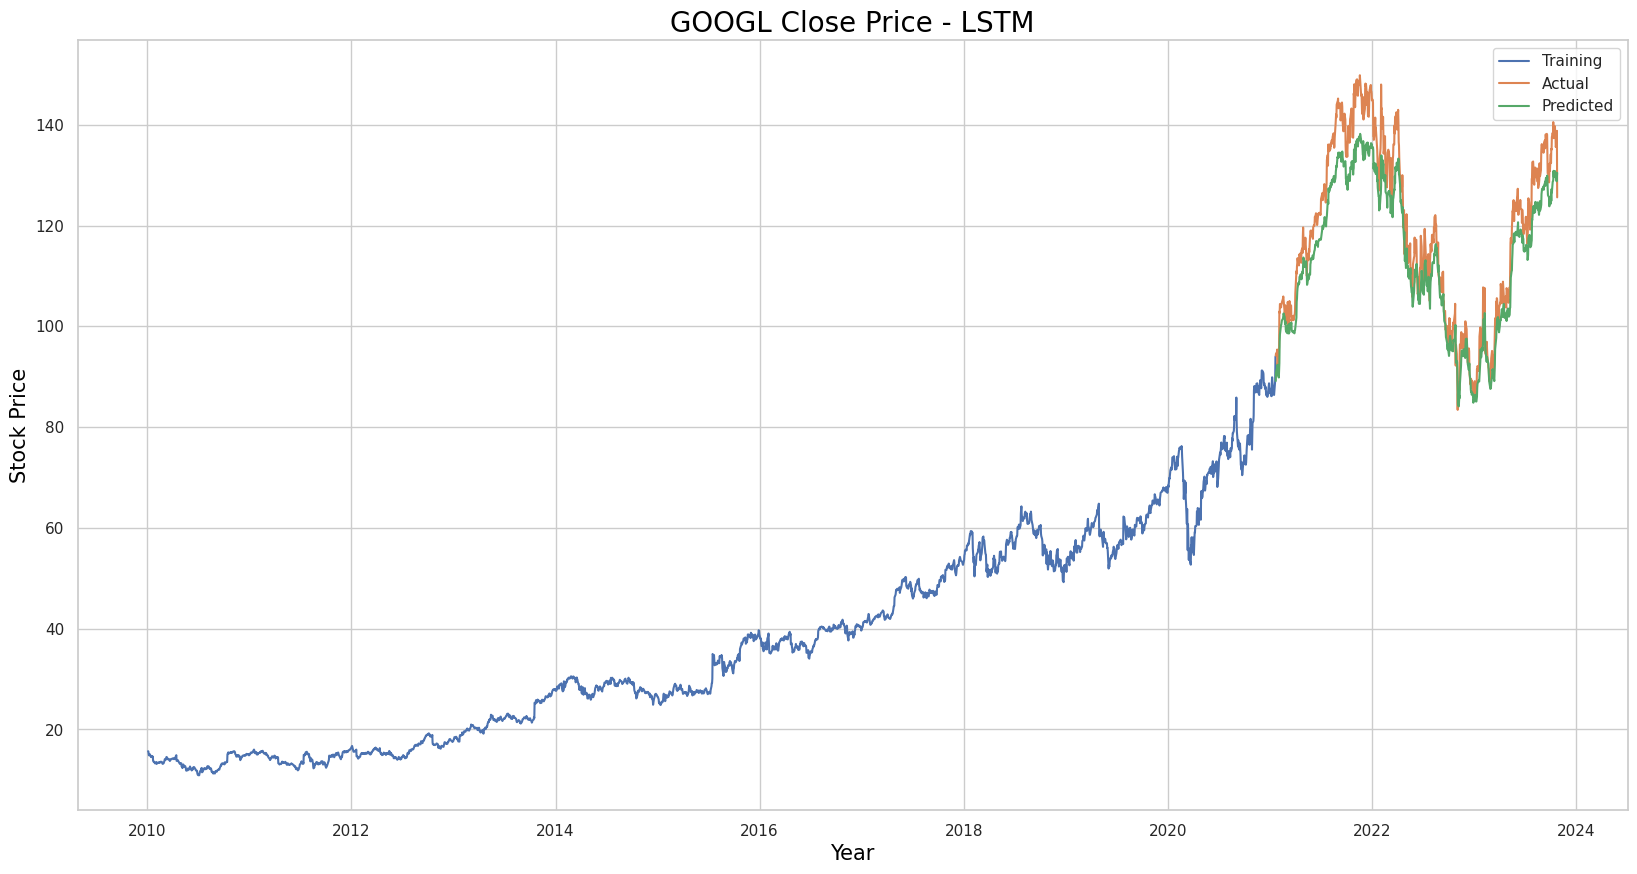

In [35]:
# Plot predicted vs actual values  
train = googl_adj[:training_data_len]
test = googl_adj[training_data_len:]
test['Predictions'] = predictions

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("GOOGL Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

In [36]:
# Show the actual and predicted prices  
test

,Adj Close,Predictions
Date,,
2021-01-21,94.207497,89.160263
2021-01-22,94.627998,90.812500
2021-01-25,94.713997,91.562912
2021-01-26,95.397499,91.862488
2021-01-27,90.946999,92.370155
...,...,...
2023-10-19,137.750000,129.960602
2023-10-20,135.600006,130.251312
2023-10-23,136.500000,128.792908


In [37]:
# Predict Adjusted Close price for GOOGL stock for October 27th 2023   
# get the quote
GOOGL_quote = yf.download("GOOGL", start="2015-07-10", end="2023-10-27")
# Create new df
new_df = GOOGL_quote.filter(['Adj Close'])
# Get last 165 days closing price and convert df to array])
last_165_days = new_df[-165:].values
# Scale data to be values between 0 and 1
last_165_days_scaled = scaler.transform(last_165_days)
# Create empty list
X_test = []
# Append last 165 days 
X_test.append(last_165_days_scaled)
# Convert the X_test data set to numpy array
X_test = np.array(X_test)
# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted price
pred_price = LSTM_model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 51ms/step
[[121.997826]]


In [38]:
# Actual price
GOOGL_quote2 = yf.download("GOOGL", start="2023-10-26", end="2023-10-27")
print(GOOGL_quote2['Adj Close'])

[*********************100%%**********************]  1 of 1 completed
Date
2023-10-26    122.279999
Name: Adj Close, dtype: float64


## Predicted Adjusted Close price for 10/27/2023 was 121.99 or ~122 but the Actual price was 122.279 or ~122.28. I was off by  0.2308% !!
# Last update: 10/29/2023 21:17